In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
import shapely.vectorized as sv 
from scipy.spatial.distance import cdist 

In [3]:
# read bolinas nodes
nodes_df = pd.read_csv('../network_inputs/osm_nodes.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)], crs='epsg:4326')
display(nodes_gdf.head(2))
# read visitor nodes
visitor_nodes_df = pd.read_csv('../network_inputs/osm_nodes_visitor_parking.csv')
visitor_nodes_gdf = gpd.GeoDataFrame(visitor_nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(visitor_nodes_df.lon, visitor_nodes_df.lat)], crs='epsg:4326')
display(visitor_nodes_gdf.head(2))

,node_id_igraph,node_osmid,lon,lat,signal,geometry
0,0,110418187,-122.649946,37.902311,NaN,POINT (-122.64995 37.90231)
1,1,110392834,-122.711450,37.901207,NaN,POINT (-122.71145 37.90121)


,node_id_igraph,node_osmid,lon,lat,signal,geometry
0,7,110421520,-122.686998,37.906398,NaN,POINT (-122.68700 37.90640)
1,11,110421540,-122.687898,37.904398,NaN,POINT (-122.68790 37.90440)


In [4]:
### Get the OSMid of the closest node to each parcel
bolinas_parcels = pd.read_csv('parcels/parcels_bolinas/parcels_bolinas.csv')
household_parcels = bolinas_parcels[bolinas_parcels['UseCd']==11].reset_index() ### only UseCd 11 has household size>0 (=1)
household_parcels = gpd.GeoDataFrame(household_parcels, crs='epsg:4326',
                                     geometry=household_parcels['WKT'].apply(loads))

household_parcels['centroid'] = household_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
household_parcels = household_parcels.set_geometry('centroid')
household_parcels['c_x'] = household_parcels['centroid'].x
household_parcels['c_y'] = household_parcels['centroid'].y
nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
nodes_osmid = nodes_gdf['node_osmid'].values

def get_closest_node(parcel_x, parcel_y):
    return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy).argmin()]

household_parcels['closest_node'] = household_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)
display(household_parcels.head(2))
household_parcels.shape
# parcels_evac.to_csv(absolute_path+'/outputs/parcels_evac.csv', index=False)

,index,WKT,WKT.1,Acres,UseCd,UseCdDesc,Parcel,AssessorSi,SHAPE_STAr,SHAPE_STLe,Prop_ID,geometry,centroid,c_x,c_y,closest_node
0,7,"POLYGON ((-122.705885636748 37.9437779330562,-...",MULTIPOLYGON (((-122.705885636748 37.943777933...,0.504,11,Single-Resid. - Improved,18810004,5855 STATE ROUTE 1,21985.887695,660.043465,188-100-04,"POLYGON ((-122.70589 37.94378, -122.70621 37.9...",POINT (-122.70613 37.94406),-122.706126,37.944060,110396428
1,8,"POLYGON ((-122.705569630863 37.9429819296033,-...",MULTIPOLYGON (((-122.705569630863 37.942981929...,2.124,11,Single-Resid. - Improved,18810005,5775 STATE ROUTE 1,92541.282227,1226.858154,188-100-05,"POLYGON ((-122.70557 37.94298, -122.70676 37.9...",POINT (-122.70628 37.94326),-122.706284,37.943258,110396428


(595, 16)

In [21]:
local_comm_dict = {
    0: {'comm_nm': 'fire_radio', 'pct_pop': [5, 5, 5], 'info_rate': [150, 150, 150], 'start_time': 16*60},
    1: {'comm_nm': 'ham_radio', 'pct_pop': [5, 5, 5], 'info_rate': [150, 150, 150], 'start_time': 17*60},
    2: {'comm_nm': 'social_media', 'pct_pop': [20, 10, 0], 'info_rate': [300, 150, 0], 'start_time': 25*60},
    3: {'comm_nm': 'code_red', 'pct_pop': [25, 15, 0], 'info_rate': [75, 45, 0], 'start_time': 60*60},
    4: {'comm_nm': 'cell_phone', 'pct_pop': [30, 15, 0], 'info_rate': [22.5, 22.5, 0], 'start_time': 25*60},
    5: {'comm_nm': 'door_to_door', 'pct_pop': [5, 30, 60], 'info_rate': [2.5, 2.5, 2.5], 'start_time': 65*60},
    100: {'comm_nm': 'none', 'pct_pop': [10, 20, 30], 'info_rate': [0, 0, 0]}}
visitor_comm_dict = {
    2: {'comm_nm': 'social_media', 'pct_pop': [50, 25, 0], 'info_rate': [300, 150, 0], 'start_time': 25*60},
    3: {'comm_nm': 'code_red', 'pct_pop': [25, 12.5, 0], 'info_rate': [75, 45, 0], 'start_time': 60*60},
    4: {'comm_nm': 'cell_phone', 'pct_pop': [25, 12.5, 0], 'info_rate': [22.5, 22.5, 0], 'start_time': 25*60},
    100: {'comm_nm': 'none', 'pct_pop': [0, 50, 100], 'info_rate': [0, 0, 0]}}

random_seed = 20
np.random.seed(random_seed)
commscen_id = 2
vphh = 2
visitor_cnts = 300 ### 500 vehicles

def assign_depttime(x, d):
    rate = d[x['comm']]['info_rate'][commscen_id]/60
    ### household inform rate is assumed to be half of the population informed rate
    household_rate = rate/2
    if household_rate == 0:
        return 1e6
    else:
        scale = 1/household_rate
        ### a random delay between 15-30 minutes
        start_time = d[x['comm']]['start_time'] + np.random.uniform(15*60, 30*60)
        return np.random.gamma(x['event_cnt'], scale=scale)+start_time

### local residents origin
local_residents_origin = household_parcels['closest_node'].values.tolist()
# Comm method trigger evacuation (not considering sight)
local_residents_comm = np.random.choice([k for k in local_comm_dict.keys()], 
                                        p=[v['pct_pop'][commscen_id]/100 for v in local_comm_dict.values()],
                                        size=len(local_residents_origin))
local_residents_od_df = pd.DataFrame({'parcel': household_parcels['Parcel'].values.tolist(), 'origin_osmid': local_residents_origin, 'comm': local_residents_comm})
local_residents_od_df = local_residents_od_df.sample(frac=1).reset_index(drop=True)
local_residents_od_df['event_cnt'] = local_residents_od_df.groupby('comm').cumcount()
local_residents_od_df['dept_time'] = local_residents_od_df.apply(lambda x: assign_depttime(x, local_comm_dict), axis=1)
local_residents_od_df['type'] = 'local'
print(local_residents_od_df.groupby('comm').agg({'dept_time': np.mean}))

### visitor origin
visitor_vehicle_origin = np.random.choice(visitor_nodes_gdf['node_osmid'], size=visitor_cnts)
visitor_vehicle_comm = np.random.choice([k for k in visitor_comm_dict.keys()], 
                                        p=[v['pct_pop'][commscen_id]/100 for v in visitor_comm_dict.values()],
                                        size=len(visitor_vehicle_origin))
visitor_vehicle_od_df = pd.DataFrame({'origin_osmid': visitor_vehicle_origin, 'comm': visitor_vehicle_comm})
visitor_vehicle_od_df = visitor_vehicle_od_df.sample(frac=1).reset_index(drop=True)
visitor_vehicle_od_df['event_cnt'] = visitor_vehicle_od_df.groupby('comm').cumcount()
visitor_vehicle_od_df['dept_time'] = visitor_vehicle_od_df.apply(lambda x: assign_depttime(x, visitor_comm_dict), axis=1)
visitor_vehicle_od_df['type'] = 'visitor'
visitor_vehicle_od_df['parcel'] = None
od_df = pd.concat([local_residents_od_df]*vphh+[visitor_vehicle_od_df])
od_df['dept_time'] = np.round(od_df['dept_time'],0)

# if communication scenario 1, can go north or south
if commscen_id == 0:
    od_df['destin_osmid'] = np.random.choice(['110360959', '110397253'], size=od_df.shape[0])
else:
    od_df['destin_osmid'] = '110397253'
od_df.to_csv('od_csv/resident_visitor_od_rs{}_commscen{}_vphh{}_visitor{}.csv'.format(random_seed, commscen_id+1, vphh, visitor_cnts), index=False)

           dept_time
comm                
0        2333.330503
1        2371.421338
5       13472.804609
100   1000000.000000


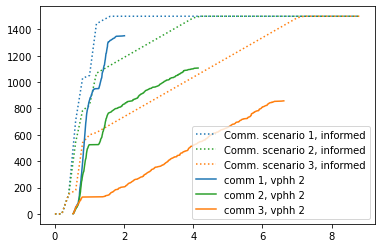

In [8]:
import matplotlib.pyplot as plt

comm_model_t = np.arange(0, 9, step=0.2)
comm_model_informed1 = [0, 0, 150, 707.5, 1030, 1050, 1442.5, 1472.5, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
comm_model_informed2 = [0, 0, 150, 545, 785, 825, 1067.5, 1097.5, 1127.5, 1157.5, 1187.5, 1217.5, 1247.5, 1277.5, 1307.5, 1337.5, 1367.5, 1397.5, 1427.5, 1457.5, 1487.5, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
comm_model_informed3 = [0, 0, 150, 180, 540, 600, 617.5, 647.5, 677.5, 707.5, 737.5, 767.5, 797.5, 827.5, 857.5, 887.5, 917.5, 947.5, 977.5, 1007.5, 1037.5,1067.5, 1097.5, 1127.5, 1157.5, 1187.5, 1217.5, 1247.5, 1277.5, 1307.5, 1337.5, 1367.5, 1397.5, 1427.5, 1457.5, 1487.5, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]

random_seed, visitor_cnts = 0, 300
fig, ax = plt.subplots()
ax.plot(comm_model_t, comm_model_informed1, c='C0', ls=':', label='Comm. scenario 1, informed')
ax.plot(comm_model_t, comm_model_informed2, c='C2', ls=':', label='Comm. scenario 2, informed')
ax.plot(comm_model_t, comm_model_informed3, c='C1', ls=':', label='Comm. scenario 3, informed')
colors = {1: 'C0', 2: 'C2', 3: 'C1'}
for vphh in [2]:
    for comm_id in [1, 2, 3]:
        od_df = pd.read_csv('od_csv/resident_visitor_od_rs{}_commscen{}_vphh{}_visitor{}.csv'.format(random_seed, comm_id, vphh, visitor_cnts))
        od_df = od_df.loc[od_df['dept_time']<3600*20]
        od_plot = od_df.dropna(subset=['dept_time']).groupby('dept_time').size().reset_index().rename(columns={0:'dept_cnts'})
        ax.plot(od_plot['dept_time']/3600, od_plot['dept_cnts'].cumsum(), c=colors[comm_id], label='comm {}, vphh {}'.format(comm_id, vphh))
        # break
plt.legend()